In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 75%; }
</style>
"""))

In [2]:
%matplotlib inline
import os
import sys
import gc
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.utilities.transformer import Transformer
from src.learning.training.generator import Generator, GenFiles
from src.learning.models import create_nvidia_cnn, create_mlp, \
                                create_standalone_nvidia_cnn, create_standalone_resnet, \
                                create_multi_model_2, create_multi_model_3, create_multi_cnn

In [12]:
def plot_stuff(title, plot_elem, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #x = np.arange(0, len(plot_elems[0]['data']), 1)
    
    #for plot_elem in plot_elems:
    #    plt.errorbar(x, plot_elem['data'], yerr=plot_elem['error'], label=plot_elem['label'], alpha=plot_elem['alpha'], fmt='-o', capsize=5)
    
    plt.plot(list(range(1,16)), plot_elem['data'])
    plt.grid(axis='both')
    #plt.legend(loc='best', prop={'size': 15})
    plt.show()
    plt.savefig('./' + title + '.png')
    
def get_model_num(model_path, model_prefix):
    model_files = [fn for fn in os.listdir(model_path) if fn.startswith(model_prefix) and fn.endswith('.h5') and 'dagger_' not in fn]
    # expected format is "model_n1_m1_9.h5"
    existing_nums = [int(fn.split('_')[3].split('.')[0]) for fn in model_files]
    
    if len(existing_nums) == 0:
        return 1
    else:
        latest_num = sorted(existing_nums)[-1]
        return int(latest_num) + 1

In [ ]:
config_manager = ConfigurationManager()
config = config_manager.config

memory_variants = [(1, 1), (2, 1), (2, 2), (4, 1), (4, 2), (6, 1), (6, 2)]
memory_variants = memory_variants[:1]
memory = memory_variants[0]

model_path = '../../training/models/'

In [ ]:
# Model experiments

epochs = 6
batch_size = 32
verbose = 1

losses = []
val_losses = []

generator = Generator(config, memory_tuple=memory, base_path='../../training/', batch_size=batch_size, column_mode='steer')
frame_shape, numeric_shape, diff_shape = generator.get_shapes()
tqdm.write('Target shape: {}'.format(diff_shape))
tqdm.write('Input shapes: {}; {}'.format(frame_shape, numeric_shape))

models = []

#mlp = create_mlp(input_shape=numeric_shape)
#cnn = create_cnn_nvidia(input_shape=frame_shape)
#models.append((create_multi_model_3(mlp, cnn, output_shape=diff_shape), generator.generate_with_numeric))

for model, generate_method in tqdm(models):
    result_desc = 'n{}_m{}'.format(*memory)
    tqdm.write(result_desc)

    hist = model.fit(generate_method(data='train'),
                     steps_per_epoch=generator.train_batch_count,
                     validation_data=generate_method(data='test'),
                     validation_steps=generator.test_batch_count,
                     epochs=epochs, verbose=verbose)

    model_file_prefix = 'model_n{}_m{}'.format(*memory)
    model_file_suffix = '_{}.{}'

    model_number = get_model_num(model_path, model_file_prefix)
    plot_model(model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
    model.save(model_path + model_file_prefix + model_file_suffix.format(model_number, 'h5'))
    
    current_loss = hist.history['loss']
    current_val_loss = hist.history['val_loss'] 
    
    losses.append(current_loss)
    val_losses.append(current_val_loss)
    
    tqdm.write("Loss per epoch: {}".format(current_loss))
    tqdm.write("Validation loss per epoch: {}".format(current_val_loss))
    
    gc.collect()

os.system("printf '\a'")

In [ ]:
# Memory experiments on steering + throttle models

epochs = 11
batch_size = 32
verbose = 1

losses = []
val_losses = []
    
for memory in tqdm(memory_variants):
    result_desc = 'n{}_m{}'.format(*memory)
    tqdm.write(result_desc)
    
    generator = Generator(config, memory_tuple=memory, base_path='../../training/', batch_size=batch_size, column_mode='steer')
    frame_shape, numeric_shape, diff_shape = generator.get_shapes()
    tqdm.write('Target shape: {}'.format(diff_shape))
    tqdm.write('Input shapes: {}; {}'.format(frame_shape, numeric_shape))
    
    #model = create_standalone_nvidia_cnn(activation='linear', input_shape=frame_shape, output_shape=diff_shape)
    model = create_standalone_resnet(activation='linear', input_shape=frame_shape, output_shape=diff_shape)
    
    #mlp = create_mlp(input_shape=numeric_shape)
    #cnn = create_nvidia_cnn(input_shape=frame_shape)
    #model = create_multi_model_3(mlp, cnn, output_shape=diff_shape)

    hist = model.fit(generator.generate_with_numeric(data='train'),
                     steps_per_epoch=generator.train_batch_count,
                     validation_data=generator.generate_with_numeric(data='test'),
                     validation_steps=generator.test_batch_count,
                     epochs=epochs, verbose=verbose)

    model_file_prefix = 'model_n{}_m{}'.format(*memory)
    model_file_suffix = '_{}.{}'

    model_number = get_model_num(model_path, model_file_prefix)
    plot_model(model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
    model.save(model_path + model_file_prefix + model_file_suffix.format(model_number, 'h5'))
    
    current_loss = hist.history['loss']
    current_val_loss = hist.history['val_loss'] 
    
    losses.append(current_loss)
    val_losses.append(current_val_loss)
    
    tqdm.write("Loss per epoch: {}".format(current_loss))
    tqdm.write("Validation loss per epoch: {}".format(current_val_loss))
    
    gc.collect()
    
os.system("printf '\a'")

In [ ]:
# Memory experiments on gear models

epochs = 5
batch_size = 32
verbose = 1

gear_losses = []
gear_val_losses = []
    
for memory in tqdm(memory_variants):
    result_desc = 'n{}_m{}'.format(*memory)
    tqdm.write(result_desc)
    
    generator = Generator(config, memory_tuple=memory, base_path='../../training/', batch_size=batch_size, column_mode='all')
    frame_shape, numeric_shape, diff_shape = generator.get_shapes()
    tqdm.write('Target shape: {}'.format(diff_shape))
    tqdm.write('Input shapes: {}; {}'.format(frame_shape, numeric_shape))
    
    mlp = create_mlp(input_shape=numeric_shape)
    cnn = create_cnn_nvidia(input_shape=frame_shape)
    gear_model = create_multi_model_2(mlp, cnn, output_shape=2)

    hist = gear_model.fit(generator.generate_with_numeric(data='train'),
                          steps_per_epoch=generator.train_batch_count,
                          validation_data=generator.generate_with_numeric(data='test'),
                          validation_steps=generator.test_batch_count,
                          epochs=epochs, verbose=verbose)

    model_file_prefix = 'gear_model_n{}_m{}'.format(*memory)
    model_file_suffix = '_{}.{}'

    model_number = get_model_num(model_path, model_file_prefix)
    plot_model(gear_model, to_file=model_path + model_file_prefix + model_file_suffix.format(model_number, 'png'), show_shapes=True)
    gear_model.save(model_path + model_file_prefix + model_file_suffix.format(model_number, 'h5'))
    
    current_loss = hist.history['loss']
    current_val_loss = hist.history['val_loss'] 
    
    gear_losses.append(current_loss)
    gear_val_losses.append(current_val_loss)
    
    tqdm.write("Loss per epoch: {}".format(current_loss))
    tqdm.write("Validation loss per epoch: {}".format(current_val_loss))
    
    gc.collect()

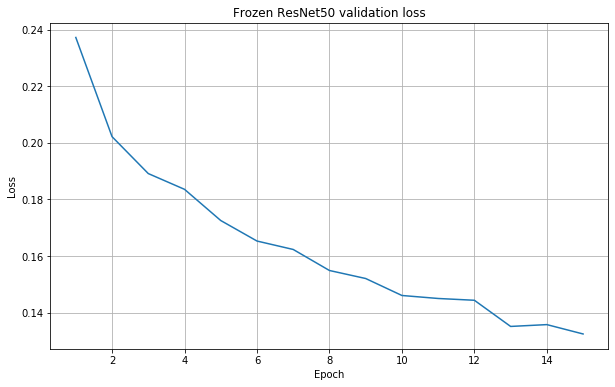

<Figure size 432x288 with 0 Axes>

In [15]:
loss_data = []
val_loss_data = []

#for i in range(0, len(losses)):
#    val_loss_data.append({'data': val_losses[i], 'label': key, 'alpha': 1.0})
#    loss_data.append({'data': losses[i], 'label': key, 'alpha': 1.0})

#print(val_losses[0])
#print(losses[0])

val_losses = [0.23722123346760812, 0.2021795028936132, 0.18914811264400655, 0.18357830732274685, 0.17255998199404246, 0.1653162681023198, 0.16233782802043856, 0.15490955155714198, 0.1520774152822877, 0.14608371565096098, 0.14502559111425836, 0.1443929300018474, 0.13514944303011234, 0.13579440341497293, 0.13248746392915983]
#val_loss_data = {'data': val_losses[0], 'label': 'Validation loss', 'alpha': 1.0}
val_loss_data = {'data': val_losses, 'label': 'Validation loss', 'alpha': 1.0}
plot_stuff('Frozen ResNet50 validation loss', val_loss_data, figsize=(10, 6))

# pure CNN val losses:
#[0.26208932510423677, 0.2431999818281835, 0.2419706503846295, 0.23596142043026802, 0.23266474507511703, 0.23412484373181353, 0.2326298898092971, 0.23301200696808624, 0.23368331607215492, 0.23286442807803787, 0.23275732213542574, 0.23076997644262554, 0.2311641180217164, 0.23385834362601612, 0.22848430069169184]
# mlp+cnn val losses:
#[0.23286499741061903, 0.22599081518450762, 0.21669530799614317, 0.21577402521033284, 0.2210044350096035, 0.2160146362561402, 0.21713066533458034, 0.2175480440161987, 0.2224359231968782, 0.2169322732449313, 0.21340483304530475, 0.21505828258435014, 0.22156153662170439, 0.22231227188087482, 0.2156986638714737]
# resnet val losses:
#[0.23722123346760812, 0.2021795028936132, 0.18914811264400655, 0.18357830732274685, 0.17255998199404246, 0.1653162681023198, 0.16233782802043856, 0.15490955155714198, 0.1520774152822877, 0.14608371565096098, 0.14502559111425836, 0.1443929300018474, 0.13514944303011234, 0.13579440341497293, 0.13248746392915983]

In [ ]:
loss_data = {'data': losses[0], 'label': 'Loss', 'alpha': 1.0}
plot_stuff('Training', loss_data, figsize=(10, 6))

In [ ]:
import tensorflow as tf

generator = Generator(config, memory_tuple=memory, base_path='../../training/', batch_size=32, column_mode='steer', separate_files=True)
frame_shape, numeric_shape, diff_shape = generator.get_shapes()

shapes = ([50, 180, 12], ())
types = (np.float32, np.float32)

train_dataset = tf.data.Dataset.from_generator(generator.generate_single_train, output_types=types, output_shapes=shapes)
train_dataset = train_dataset.batch(batch_size=32)
train_dataset = train_dataset.shuffle(buffer_size=10)

val_dataset = tf.data.Dataset.from_generator(generator.generate_single_test, output_types=types, output_shapes=shapes)
val_dataset = val_dataset.batch(batch_size=32)
val_dataset = val_dataset.shuffle(buffer_size=10)

model = create_cnn_alone(input_shape=frame_shape, output_shape=diff_shape)

hist = model.fit(train_dataset,
                 steps_per_epoch=generator.train_batch_count,
                 validation_data=val_dataset,
                 validation_steps=generator.test_batch_count,
                 epochs=10, verbose=1)